In [24]:
# auoreload shenanigans
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
from plotnine import (
    scale_x_continuous,
    scale_y_continuous,
    scale_x_discrete,
)
import polars as pl

from utils import transform_and_cmp_heights
from utils import plot_bar
from utils import get_percentages_and_concat
from utils import plot_percentage_bars
from utils import drop_nas_in_cols

In [26]:
pl.Config(fmt_str_lengths=50, set_tbl_rows=10)

In [27]:
partition_by_cols = ["quote_is_admin", "quote_is_freemailer"]

In [28]:
from utils import get_post_test_email_data


df = get_post_test_email_data().rename(
    {
        "finalized_at": "quote_finalized_at",
        "updated": "quote_updated_at",
        "is_internal": "quote_is_internal",
        "is_admin": "quote_is_admin",
        "revision": "quote_revision",
    }
)

Data found, loading...


In [29]:
freemailers = (
    open(
        "/home/rnd/projects/demand-data-exploration/data/free_email_provider_domains.txt",
        "r",
    )
    .read()
    .split("\n")
)

df = df.with_columns(
    quote_email_provider=pl.col("email").str.split("@").list.get(-1)
).with_columns(quote_is_freemailer=pl.col("quote_email_provider").is_in(freemailers))

In [30]:
df = drop_nas_in_cols(df, ["type", "country_code", "lead_time"])

Height comparison 
Before: 2652903 
After:  2652877 
Diff:  -26 (-0.00%)


In [31]:
# Pure vs mixed quotes
df = df.with_columns(
    (
        pl.when(pl.col("quote_is_admin").n_unique() > 1)
        .then(pl.lit("mixed_quote"))
        .when(pl.col("quote_is_admin") == True)
        .then(pl.lit("pure_admin_quote"))
        .otherwise(pl.lit("pure_customer_quote"))
    )
    .first()
    .over("order_uuid")
    .alias("quote_type"),
)

In [48]:
# quote_revision max
REV_MAX_THRESH = 15

dfs = {
    partition_col: (
        df.group_by("order_uuid", partition_col)
        .agg(pl.max("quote_revision").alias("quote_revision_count"))
        .with_columns(
            quote_revision_count=pl.when(
                pl.col("quote_revision_count") >= REV_MAX_THRESH
            )
            .then(REV_MAX_THRESH)
            .otherwise(pl.col("quote_revision_count"))
        )
        .partition_by(by=[partition_col], as_dict=True)
    )
    for partition_col in partition_by_cols
}

df_revisions_quote_type = get_percentages_and_concat(
    dfs["quote_is_freemailer"],
    count_col="quote_revision_count",
    group_col="quote_is_freemailer",
)

df_revisions_quote_internal = get_percentages_and_concat(
    dfs["quote_is_admin"],
    count_col="quote_revision_count",
    group_col="quote_is_admin",
)

In [49]:
df_ = (
    df.group_by("order_uuid")
    .agg(pl.max("quote_revision").alias("quote_revision_count"))
    .with_columns(
        quote_revision_count=pl.when(pl.col("quote_revision_count") >= REV_MAX_THRESH)
        .then(REV_MAX_THRESH)
        .otherwise(pl.col("quote_revision_count"))
    )
)


df_ = transform_and_cmp_heights(
    df_,
    df_.filter(pl.col("quote_revision_count") < REV_MAX_THRESH),
)

Height comparison 
Before: 462609 
After:  460960 
Diff:  -1649 (-0.36%)


In [50]:
plot_percentage_bars(
    df_revisions_quote_type,
    x="quote_revision_count",
    y="percentage_quote_revision_count",
    facet_col="quote_is_freemailer",
    plot_extras=[scale_x_continuous(breaks=[x for x in range(1, REV_MAX_THRESH + 1)])],
).save(
    filename="/home/rnd/projects/demand-data-exploration/big_plots/rev_count_freemailers.png",
    width=8,
    height=5,
)

/home/rnd/miniconda3/envs/machining_quote-dev-gpu-v2/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 8 x 5 in image.
/home/rnd/miniconda3/envs/machining_quote-dev-gpu-v2/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /home/rnd/projects/demand-data-exploration/big_plots/rev_count_freemailers.png


In [51]:
plot_percentage_bars(
    df_revisions_quote_internal,
    x="quote_revision_count",
    y="percentage_quote_revision_count",
    facet_col="quote_is_admin",
    plot_extras=[scale_x_continuous(breaks=[x for x in range(1, REV_MAX_THRESH + 1)])],
).save(
    filename="/home/rnd/projects/demand-data-exploration/big_plots/rev_count_admin.png",
    width=8,
    height=5,
)

/home/rnd/miniconda3/envs/machining_quote-dev-gpu-v2/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 8 x 5 in image.
/home/rnd/miniconda3/envs/machining_quote-dev-gpu-v2/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /home/rnd/projects/demand-data-exploration/big_plots/rev_count_admin.png


In [36]:
# add filter for either locked or external for the rev count
# maybe even add it to the beggining of the preprocessing

In [37]:
#! Remove quotes with more than REV_MAX_THRESH
df_low_revs = transform_and_cmp_heights(
    df, df.filter(pl.col("order_uuid").is_in(df_["order_uuid"]))
)

Height comparison 
Before: 2652877 
After:  2440260 
Diff:  -212617 (-8.01%)


In [38]:
del dfs, df_, df_revisions_quote_type, df_revisions_quote_internal

In [39]:
# Country codes
df_cc = transform_and_cmp_heights(
    df,
    df.filter(pl.col("country_code").n_unique().over("order_uuid") == 1),
)

Height comparison 
Before: 2652877 
After:  2638667 
Diff:  -14210 (-0.54%)


In [40]:
dfs = {
    partition_col: df_cc.partition_by(by=[partition_col], as_dict=True)
    for partition_col in partition_by_cols
}

df_cc_quote_type = get_percentages_and_concat(
    dfs["quote_is_freemailer"],
    count_col="country_code",
    group_col="quote_is_freemailer",
)

df_cc_quote_internal = get_percentages_and_concat(
    dfs["quote_is_admin"], count_col="country_code", group_col="quote_is_admin"
)

/home/rnd/miniconda3/envs/machining_quote-dev-gpu-v2/lib/python3.8/site-packages/plotnine/layer.py:344: PlotnineWarning: position_stack : Removed 286 rows containing missing values.


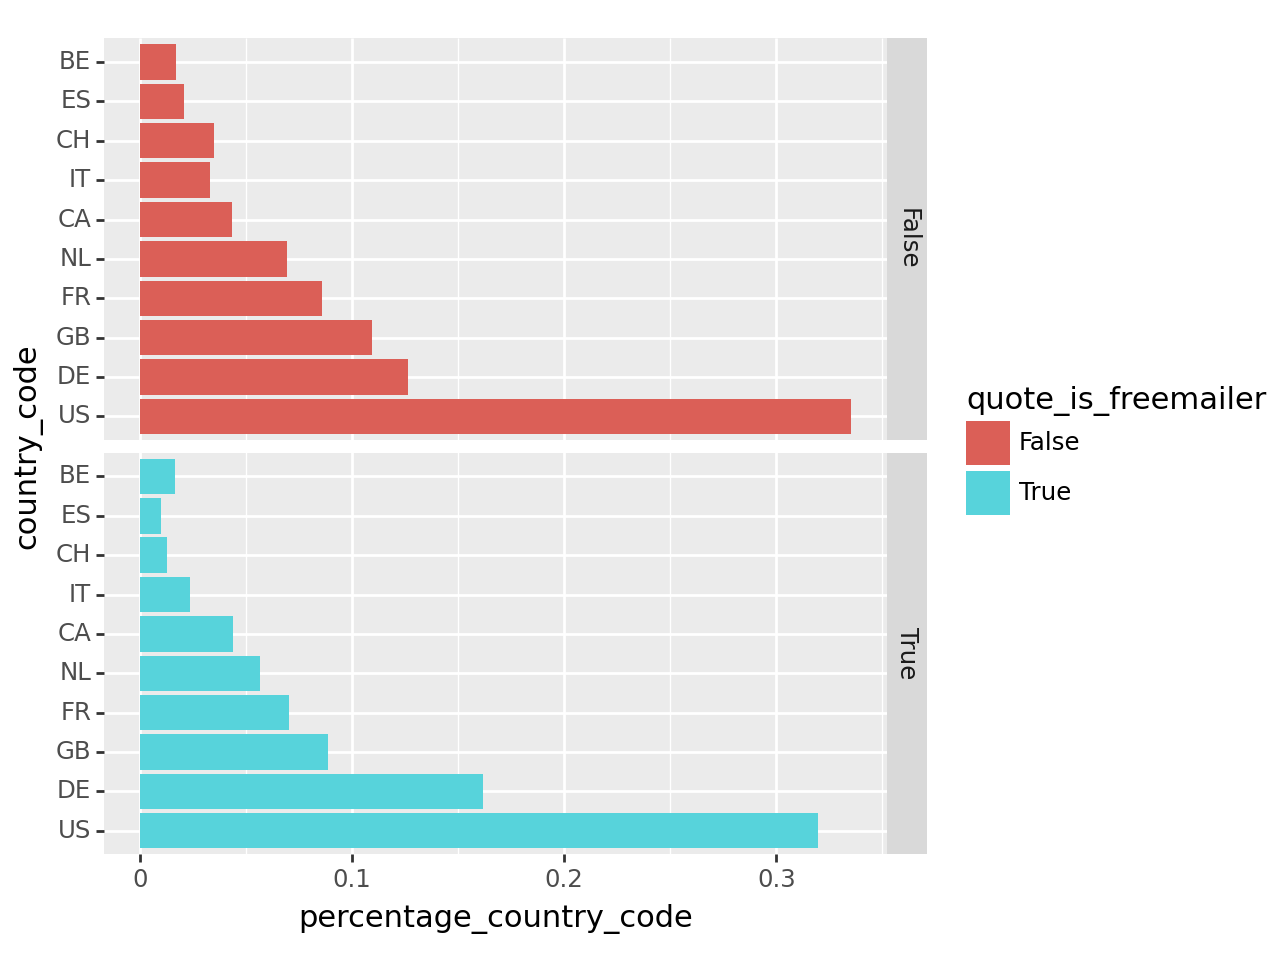

<Figure Size: (640 x 480)>

In [41]:
plot_percentage_bars(
    df_cc_quote_type,
    x="country_code",
    y="percentage_country_code",
    facet_col="quote_is_freemailer",
    plot_extras=[
        scale_x_discrete(
            limits=df_cc.get_column("country_code")
            .value_counts()
            .sort("count", descending=True)
            .get_column("country_code")[:10]
        )
    ],
)

/home/rnd/miniconda3/envs/machining_quote-dev-gpu-v2/lib/python3.8/site-packages/plotnine/layer.py:344: PlotnineWarning: position_stack : Removed 236 rows containing missing values.


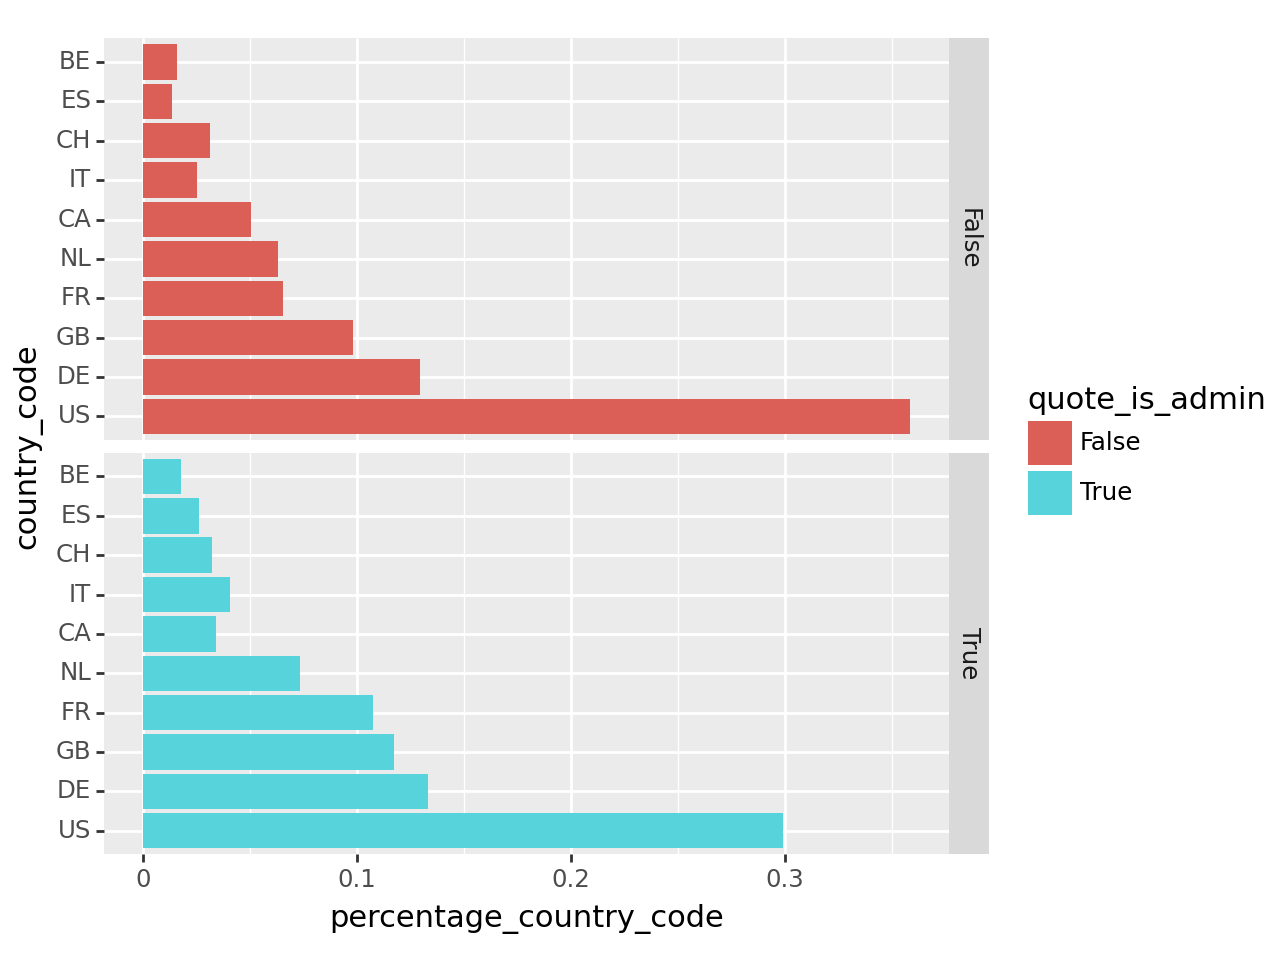

<Figure Size: (640 x 480)>

In [42]:
plot_percentage_bars(
    df_cc_quote_internal,
    x="country_code",
    y="percentage_country_code",
    facet_col="quote_is_admin",
    plot_extras=[
        scale_x_discrete(
            limits=df_cc.get_column("country_code")
            .value_counts()
            .sort("count", descending=True)
            .get_column("country_code")[:10]
        )
    ],
)

In [43]:
#! Remove orders with more than 1 country code
df_no_multiple_ccs = transform_and_cmp_heights(
    df, df.filter(pl.col("order_uuid").is_in(df_cc["order_uuid"]))
)

Height comparison 
Before: 2652877 
After:  2638667 
Diff:  -14210 (-0.54%)


In [44]:
del dfs, df_cc_quote_type, df_cc_quote_internal

In [45]:
# talk with jurien about outliers
# conv rate has big spikes some days (was it bots that created these orders?) analytics might have a filter for this
# might make sense to filter these out from demand data too
# ip/email/etc address with a lot of quotes but conversion rate is low (or none)

In [46]:
df.write_parquet(
    "/home/rnd/projects/demand-data-exploration/data/df_post_outlier_removal.parquet"
)